In [11]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn.modules.loss import *
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from pathlib import Path
# %matplotlib notebook

In [12]:
from Loss.triplet import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
import Datasets.ModelData as md

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

fulltrainset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/train', train=True,
                                        download=True, transform=transform)
trainset = torch.utils.data.dataset.Subset(fulltrainset, np.arange(3200))

fullvalset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/test', train=False,
                                       download=True, transform=transform)
valset = torch.utils.data.dataset.Subset(fullvalset, np.arange(3200))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

## Baseline

In [ ]:
model_base = nn.Sequential(
     nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
     nn.BatchNorm2d(32),
     nn.ReLU(),
    
     nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     nn.BatchNorm2d(32),
     nn.ReLU(),
     
     nn.MaxPool2d(kernel_size=2, stride=2),
    
     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     nn.BatchNorm2d(64),
     nn.ReLU(),
     
     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     nn.BatchNorm2d(64),
     nn.ReLU(),
     
     nn.MaxPool2d(kernel_size=2, stride=2),
    
     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     nn.BatchNorm2d(128),
     nn.ReLU(),
     
     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     nn.BatchNorm2d(128),
     nn.ReLU(),
     
     nn.MaxPool2d(kernel_size=2, stride=2),
    
     Flatten(),
    
     nn.Linear(4 * 4 * 128, 512),
     nn.Linear(512, 256),
     nn.Linear(256, 10))

sess_base = Session(model_base, nn.CrossEntropyLoss(), optim.AdamW, 1e-3)

In [ ]:
lr_find(sess_base, trainloader, start_lr=1e-4)

In [ ]:
sess_base.set_lr(1e-3)

In [ ]:
validator = Validator(valloader, OneHotAccuracy(), save_best=True, model_dir='./base')
lr_scheduler = CosAnneal(len(trainloader), T_mult=2)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess_base.train(schedule, 63)

## Triplet Loss 


In [16]:
class TripletRegularizedCrossEntropyLoss(nn.Module):
    def __init__(self, alpha, margin):     
        super().__init__()
        self.alpha = alpha
        self.margin = margin
        
    def forward(self, x, y):
        loss = F.cross_entropy(x[-1], y)
        triplet = 0
        
        for layer in x[:-1]:
            triplet += batch_hard_triplet_loss(layer.view(layer.size(0), -1), y, self.margin)
            
        # triplet *= min(self.alpha/math.sqrt(loss.item()), 1)
        triplet *= self.alpha
            
        return loss + triplet
      
class CustomOneHotAccuracy(OneHotAccuracy):
    def __init__(self):
        super().__init__()
        self.reset()

    def update(self, output, label):
        super().update(output[-1], label)
        
class SelectiveSequential(nn.Module):
    def __init__(self, to_select, modules_dict):
        super(SelectiveSequential, self).__init__()
        for key, module in modules_dict.items():
            self.add_module(key, module)
        self._to_select = to_select
    
    def forward(self, x):
        list = []
        for name, module in self._modules.items():              
            #if name in self._to_select:
            #    list.append(module(x.data))
            
            x = module(x)      
            
            if name in self._to_select:
                list.append(x)
                
        return list
    

In [20]:
model = SelectiveSequential(
    ['max3', 'fc1', 'fc2', 'out'],
    {'conv32a': nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
     'batch32a': nn.BatchNorm2d(32),
     'act32a': nn.ReLU(),
    
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     'batch32b': nn.BatchNorm2d(32),
     'act32b': nn.ReLU(),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     'batch64a': nn.BatchNorm2d(64),
     'act64a': nn.ReLU(),
     
     'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     'batch64b': nn.BatchNorm2d(64),
     'act64b': nn.ReLU(),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     'batch128a': nn.BatchNorm2d(128),
     'act128a': nn.ReLU(),
     
     'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     'batch128b': nn.BatchNorm2d(128),
     'act128b': nn.ReLU(),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(4 * 4 * 128, 512),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(512, 256),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(256, 10)})

In [21]:
criterion = TripletRegularizedCrossEntropyLoss(.01, .5)
sess = Session(model, criterion, optim.AdamW, 1e-3)

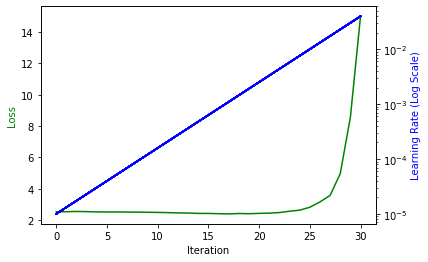

In [19]:
lr_find(sess, trainloader, start_lr=1e-5)

In [22]:
sess.set_lr(1e-3)

In [24]:
validator = Validator(valloader, CustomOneHotAccuracy())
lr_scheduler = CosAnneal(len(trainloader), T_mult=2)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 128)

Validating: 100%|██████████| 50/50 [00:01<00:00, 37.89it/s]

Training Loss: 1.8915936946868896 Validaton Loss: 1.7950568199157715 Validation Accuracy: 0.434375


Validating: 100%|██████████| 50/50 [00:01<00:00, 35.71it/s]

Training Loss: 1.7927590608596802 Validaton Loss: 1.78704833984375 Validation Accuracy: 0.4353125


Validating: 100%|██████████| 50/50 [00:01<00:00, 31.77it/s]

Training Loss: 1.586833119392395 Validaton Loss: 1.5472816228866577 Validation Accuracy: 0.5125


Validating: 100%|██████████| 50/50 [00:01<00:00, 35.75it/s]

Training Loss: 1.6001113653182983 Validaton Loss: 1.6504478454589844 Validation Accuracy: 0.476875


Validating: 100%|██████████| 50/50 [00:01<00:00, 37.52it/s]

Training Loss: 1.4694207906723022 Validaton Loss: 1.532349705696106 Validation Accuracy: 0.525


Validating: 100%|██████████| 50/50 [00:01<00:00, 37.05it/s]

Training Loss: 1.2324230670928955 Validaton Loss: 1.3925355672836304 Validation Accuracy: 0.565


Validating: 100%|██████████| 50/50 [00:01<00:00, 37.13it/s]

Training Loss: 1.0270888805389404 Validaton Loss: 1.3209928274154663 Validation Accuracy: 0.59375


Validating: 100%|██████████| 50/50 [00:01<00:00, 37.42it/s]

Training Loss: 1.213146686553955 Validaton Loss: 1.568785548210144 Validation Accuracy: 0.5296875


Validating: 100%|██████████| 50/50 [00:01<00:00, 35.81it/s]

Training Loss: 1.122331976890564 Validaton Loss: 1.476136326789856 Validation Accuracy: 0.551875


KeyboardInterrupt: 